# Test case LVV-T1074: Sky Brightness precision

> **The maximum error in the precision of the sky brightness determination shall be less than SBPerc = 1 percent.**

This test verifies the following requirements:

- LSR-REQ-0093-V-07: Sky brightness determination (https://rubinobs.atlassian.net/browse/LVV-9800)
- OSS-REQ-0387-V-05: Sky Brightness precision (https://rubinobs.atlassian.net/browse/LVV-13366)


#### Discussion

This test notebook can be run using data products produced during regular reprocessing campaigns executed by the Data Management pipelines team.

Initial testing of this notebook was performed using data in the following collections:

- ComCam: `LSSTComCam/runs/DRP/DP1/w_2025_17/DM-50530`
- HSC RC2: `HSC/runs/RC2/w_2024_46/DM-47577`


In [1]:
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import sigma_clip
from lsst.daf.butler import Butler
from lsst.utils.packages import getEnvironmentPackages
from matplotlib.lines import Line2D
from tqdm import tqdm, trange


def print_session_info():
    # Time info
    print(f"# Session Info on {time.strftime('%Y-%m-%d at %H:%M:%S %Z', time.localtime(time.time()))}\n")

    # Python info
    print(f"## Python Interpreter\n\nVersion: {sys.version}  \nExecutable: {sys.executable}\n")

    # LSST info
    packages = getEnvironmentPackages(True)
    dev_packages = {"lsst_distrib": packages["lsst_distrib"]}
    dev_packages.update({k: v.split("@")[0] for k, v in packages.items() if "LOCAL" in v})
    print("## Science Pipelines\n\n" + "\n".join(f"{k:<20} {v}" for k, v in dev_packages.items()))


print_session_info()

# Session Info on 2025-06-26 at 01:08:10 PDT

## Python Interpreter

Version: 3.12.9 | packaged by conda-forge | (main, Feb 14 2025, 08:00:06) [GCC 13.3.0]  
Executable: /sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/bin/python3.12

## Science Pipelines

lsst_distrib         gdfb3db0272+af263c96c9 (w_2025_25 w_latest)


#### Methodology

We will measure the precision of the sky brightness using caibrated exposure (`calexp`) data.
The following will be executed _for each detector, for each test visit_:

- Retrieve the sky-subtracted `calexp`;
- Convert image flux to nanojanskies;
- Measure and record the per-pixel standard deviation of the background pixel fluxes, ignoring masked detections and artifacts.

We also measure this metric using the `sourceTable_visit` tables.
The following will be executed _for each test visit_:

- Trim the `sourceTable_visit` table to include only sky sources;
- Divide the summed `ap09Flux` fluxes by the circular aperture area to derive the mean fluxes within each aperture;
- Measure and record the standard deviation of these sky source mean fluxes (equivalent to the standard deviation of an image binned by the aperture area);
- Correct these mean fluxes by $\sqrt{N}$, where $N$ is the number of pixels in the measurement aperture, to estimate the per-pixel standard deviation equivalent to that measured from the image background directly;
- Record the ratios between the standard deviations of the image backgrounds and sky source fluxes to the visit's mean sky brightness, derived as the mean of the `calexp` metadata `BGMEAN` parameters for all CCDs;
- Convert from the per-pixel standard deviations into a standard metric for the limiting surface brightness, $3\sigma$ on 10"x10" scales, using the pixel scales associated with each `calexp`.


#### Initialization


In [2]:
# Choose a data collection
collection = "LSSTComCam/runs/DRP/DP1/w_2025_17/DM-50530"
# collection = "HSC/runs/RC2/w_2024_46/DM-47577"

In [3]:
# Instantiate the Butler
repo = "/repo/main"
butler = Butler.from_config(repo, collections=collection)

In [4]:
# Define a visit list
instrument = collection.split("/")[0]
if instrument == "LSSTComCam":
    detectors = list(range(9))
elif instrument == "HSC":
    detectors = list(range(104))
    detectors.remove(9)  # Faulty CCD in HSC
refs = butler.query_datasets("recalibrated_star", collections=collection)
visits = [x.dataId["visit"] for x in refs if x.dataId["band"] == "g"]  # g-band only
visits = visits[: int(np.ceil(500 / len(detectors)))]  # limit to a sub-sample of visits

In [5]:
# Set the mask planes to ignore, following defaults in `background.py` used by `skyCorr`
badMaskPlanes = ["SAT", "BAD", "EDGE", "DETECTED", "DETECTED_NEGATIVE", "NO_DATA"]

In [6]:
print(f"{repo = }\n{collection = }\n{len(visits) = }")

repo = '/repo/main'
collection = 'LSSTComCam/runs/DRP/DP1/w_2025_17/DM-50530'
len(visits) = 56


#### Functions

The cells below define functions that retrieve image and metadata (`retrieveImage`) and retrieve sky sources (`retrieveSkySources`).


In [7]:
def retrieveImage(dataId, collection):
    """Retrieve the sky-subtracted calibrated exposure and associated metadata.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored

    Returns
    -------
    visitImage : `ImageF`
        Visit image with the `visit_image_background` subtracted from it, converted to
        nJy
    `skyMean` : `float`
        Clipped mean of the visit image's sky background, converted to nJy
    `skyNoise` : `float`
        Standard deviation of the visit image's background, converted to nJy
    """
    # Retrieve the image, metadata, and calibration
    visitImage = butler.get("visit_image", dataId=dataId, collections=collection)
    skyMean = visitImage.getInfo().getSummaryStats().skyBg
    skyNoise = visitImage.getInfo().getSummaryStats().skyNoise
    photoZp = visitImage.getPhotoCalib().instFluxToNanojansky(1)

    # Convert everything to nanojansky
    visitImage.image.array *= photoZp
    skyMean *= photoZp
    skyNoise *= photoZp

    return visitImage, skyMean, skyNoise

In [8]:
def retrieveSkySources(dataId, collection, aper=9):
    """Retrieve sky source aperture fluxes for a given detector / visit.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored
    aper : `int`
        Choice of sky source aperture radius. Valid are 3,6,9,12,25,35,70.
        The 9 pixel aperture is recommended as sky sources are defined as being
        >8px from the nearest detection.

    Returns
    -------
    skySources : pandas `Series`
        Total fluxes of sky sources within circular aperture of radius aper.
        Units are nJy.
    """
    # Retrieve table
    srcTab = butler.get("recalibrated_star_detector", dataId=dataId, collections=collection)
    isSky = srcTab["sky_source"] > 0  # Pick only sky sources
    skySources = srcTab[isSky]["ap%02dFlux" % (aper)]  # Units are nJy already

    return skySources

Estimation of the background and sky source standard deviations are wrapped into functions called `deriveBgNoise` and `deriveSkySourceNoise`, in the following cells:


In [9]:
def deriveBgNoise(dataId, collection):
    """Derive the clipped standard deviation of the background of
    sky-subtracted calexps for a single visit.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored

    Returns
    -------
    sigSkyBg : `float`
        Clipped standard deviation of sky-subtracted background flux, nJy
    noiseFracBg : `float`
        Ratio between sigSkyBg and mean sky brightness of exposure
    """
    # Retrieve images and metadata
    ssImage, skyMean, __ = retrieveImage(dataId, collection)

    # Mask the sky-subtracted image of sources/other things
    mask = ssImage.maskedImage.mask
    bad_mask_bit_mask = mask.getPlaneBitMask(badMaskPlanes)
    good = (mask.array.astype(int) & bad_mask_bit_mask) == 0

    # Sigma-clip background pixel fluxes
    clipSkyBackground = np.array(sigma_clip(ssImage.image.array[good], sigma=3, maxiters=3, masked=False))

    sigSkyBg = np.nanstd(clipSkyBackground)  # 1 sigma value, per pixel

    # Sky accuracy estimates
    noiseFracBg = sigSkyBg / skyMean

    return sigSkyBg, noiseFracBg

In [10]:
def deriveSkySourceNoise(dataId, collection, skyMean, aper=9):
    """Derive the clipped standard deviation of sky sources for a single visit.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored
    skyMean : `float`
        Mean sky flux for the corresponding detector
    aper : `int`
        Choice of sky source aperture radius. See retrieveSkySources()

    Returns
    -------
    sigSkySource : `float`
        Clipped standard deviation of mean sky source fluxes within aperture.
        Units are nJy.
    noiseFracSource : `float`
        Ratio between sigSkySource and mean sky brightness of exposure.
    """
    # Retrieve data
    skySources = retrieveSkySources(dataId, collection, aper)

    # Sigma-clip mean fluxes within sky source apertures
    nPix = np.pi * aper**2  # Number of pixels per aperture
    clipSkySources = np.array(sigma_clip(skySources / nPix, sigma=3, maxiters=3, masked=False))

    # The distribution of the mean fluxes within 9px radius apertures is
    # equivalent to the distribution of a binned version of the image, i.e. std
    # is reduced by the bin factor. As such, we take that out to compare
    # against the per-pixel std.
    sigSkySource = np.nanstd(clipSkySources) * np.sqrt(nPix)

    # Sky accuracy estimate
    noiseFracSource = sigSkySource / skyMean

    return sigSkySource, noiseFracSource

Derivation of an additional metric, the limiting surface brightness, is wrapped in the function `deriveLimitingSb` in the following cell:


In [11]:
def deriveLimitingSb(dataId, collection, aper=9):
    """Derive the limiting surface brightness, as defined by
    Roman et al. (2020), using sky sources for a given visit and detector. This
    is defined as 3x the standard deviation of the background flux distribution
    as averaged over 10" x 10" scales.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored
    aper : `int`
        Choice of sky source aperture radius. Valid are 3,6,9,12,25,35,70.
        The 9 pixel aperture is recommended as sky sources are defined as being
        >8px from the nearest detection.
    """
    skySources = retrieveSkySources(dataId, collection, aper=aper)

    # Derive sigma-clipped per-pixel standard deviation
    nPix = np.pi * aper**2  # Number of pixels within the circular aperture
    clipSkySources = np.array(sigma_clip(skySources / nPix, sigma=3, maxiters=3, masked=False))
    sigSkySource = np.nanstd(clipSkySources)
    # Retrieve magnitude zeropoint and pixel scale for conversion to surface brightness
    magZp = butler.get("visit_image.photoCalib", dataId, collections=collection).instFluxToMagnitude(1)
    pxScale = butler.get("visit_image.wcs", dataId, collections=collection).getPixelScale().asArcseconds()

    # Derive limiting surface brightness: 3sigma, on 10"x10" scales
    pixScaleRatio = np.sqrt(pxScale**2 / (nPix * pxScale**2))
    sigma = sigSkySource / pixScaleRatio
    muLim = -2.5 * np.log10((3 * sigma) / (pxScale * 10)) + magZp

    return muLim

#### Data Processing

For _M_ visits, derive the background standard deviations and noise ratios of all CCDs and collate into lists.


In [12]:
# Store results in a dictionary accessed by visit ID
noiseDict = {}
# Processing time here is long!
for i, vis in enumerate(tqdm(visits)):
    noiseDict[vis] = {
        "sigSkySource": [],
        "sigSkyBg": [],
        "noiseFracSource": [],
        "noiseFracBg": [],
        "muLim": [],
    }
    for det in detectors:
        dataId = {"visit": vis, "detector": det, "instrument": instrument}
        # Image backgrounds
        try:
            sigSkyBg, noiseFracBg = deriveBgNoise(dataId, collection)
            noiseDict[vis]["sigSkyBg"].append(sigSkyBg)
            noiseDict[vis]["noiseFracBg"].append(noiseFracBg)
            bgMean = sigSkyBg / noiseFracBg  # Mean of detector BG
        except Exception:
            noiseDict[vis]["sigSkyBg"].append(np.nan)
            noiseDict[vis]["noiseFracBg"].append(np.nan)
            bgMean = np.nan

        # sky sources
        try:
            sigSkySource, noiseFracSource = deriveSkySourceNoise(dataId, collection, bgMean)
            noiseDict[vis]["sigSkySource"].append(sigSkySource)
            noiseDict[vis]["noiseFracSource"].append(noiseFracSource)
        except Exception:
            noiseDict[vis]["sigSkySource"].append(np.nan)
            noiseDict[vis]["noiseFracSource"].append(np.nan)

        # Limiting surface brightness
        try:
            muLim = deriveLimitingSb(dataId, collection)
            noiseDict[vis]["muLim"].append(muLim)
        except Exception:
            noiseDict[vis]["muLim"].append(np.nan)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [19:29<00:00, 20.89s/it]


For a random sub-sample of at least five visits (or all visits, if fewer than five total), print the standard deviations derived each way to the screen, and print the ratios between these and the mean background flux.


In [13]:
print(
    "Standard deviations and ratios with mean background flux for (max) five randomly chosen calexps in %a"
    % (instrument)
)
print("==================================================================================")
rng = np.random.default_rng(12345)  # Arbitrary seed
if len(visits) < 5:
    idx = np.arange(len(visits))
else:
    idx = rng.choice(np.arange(len(visits)), size=5, replace=False)
keys = np.array(list(noiseDict.keys()))[idx]
for key in keys:
    idy = rng.choice(np.arange(9))  # Random detector ID
    print(
        "Visit %d: sigBG=%.3f nJy, sigSources=%.3f nJy, sigBG/fBG=%.3f, sigSources/fSources=%.3f, muLim=%.3f mag/arcsec^2"
        % (
            key,
            np.nanmean(noiseDict[key]["sigSkyBg"][idy]),
            noiseDict[key]["sigSkySource"][idy],
            np.nanmean(noiseDict[key]["noiseFracBg"][idy]),
            noiseDict[key]["noiseFracSource"][idy],
            np.nanmean(noiseDict[key]["muLim"][idy]),
        )
    )

Standard deviations and ratios with mean background flux for (max) five randomly chosen calexps in 'LSSTComCam'
Visit 2024112600155: sigBG=16.379 nJy, sigSources=19.324 nJy, sigBG/fBG=0.034, sigSources/fSources=0.041, muLim=27.745 mag/arcsec^2
Visit 2024110800301: sigBG=12.664 nJy, sigSources=17.338 nJy, sigBG/fBG=0.027, sigSources/fSources=0.037, muLim=27.863 mag/arcsec^2
Visit 2024110800298: sigBG=13.257 nJy, sigSources=18.213 nJy, sigBG/fBG=0.028, sigSources/fSources=0.039, muLim=27.808 mag/arcsec^2
Visit 2024112600171: sigBG=13.338 nJy, sigSources=18.439 nJy, sigBG/fBG=0.031, sigSources/fSources=0.043, muLim=27.797 mag/arcsec^2
Visit 2024110800316: sigBG=14.437 nJy, sigSources=18.017 nJy, sigBG/fBG=0.030, sigSources/fSources=0.038, muLim=27.824 mag/arcsec^2


#### Analysis

The standard deviation measured from the background measures the pixel-to-pixel uncertainty from the distribution of all background flux, while that measured from sky sources measures the same uncertainty on larger (9px radius aperture) scales. Larger standard deviations measured within apertures suggest that the backgrounds contain correlated flux, possibly leakage from detection or artifact masks.

The ratio between the standard deviation and the mean background flux subtracted from images is our defined metric to measure the `SBPerc` parameter specified in the requirement.

**From this small sub-sample of test images, the requirement is not being met.**

Limiting surface brightness is a metric used frequently by the LSB community, and can be tracked as the pipeline changes. The per-visit value is of less interest than the value derived from `deepCoadd` images, but that can be estimated using the number of images $N$ being coadded by assuming the background noise decreases as $\sqrt{N}$.


#### Plots

Below we create histograms of standard deviations, standard deviations normalized by the mean sky flux, limiting surface brightness, and standard deviations normalized by the expected Poisson noise in each detector in each visit tested.


In [14]:
# Retrieve stored dictionary values as Numpy arrays
sigSkyBgs = np.array([noiseDict[visits[i]]["sigSkyBg"] for i in range(len(visits))]).flatten()
sigSkySources = np.array([noiseDict[key]["sigSkySource"] for key in visits]).flatten()
noiseFracBgs = np.array([noiseDict[visits[i]]["noiseFracBg"] for i in range(len(visits))]).flatten()
noiseFracSources = np.array([noiseDict[key]["noiseFracSource"] for key in visits]).flatten()
muLims = np.array([noiseDict[key]["muLim"] for key in visits]).flatten()
sigSkyBgsOnPoisson = np.sqrt(sigSkyBgs * noiseFracBgs)
sigSkySourcesOnPoisson = np.sqrt(sigSkySources * noiseFracSources)

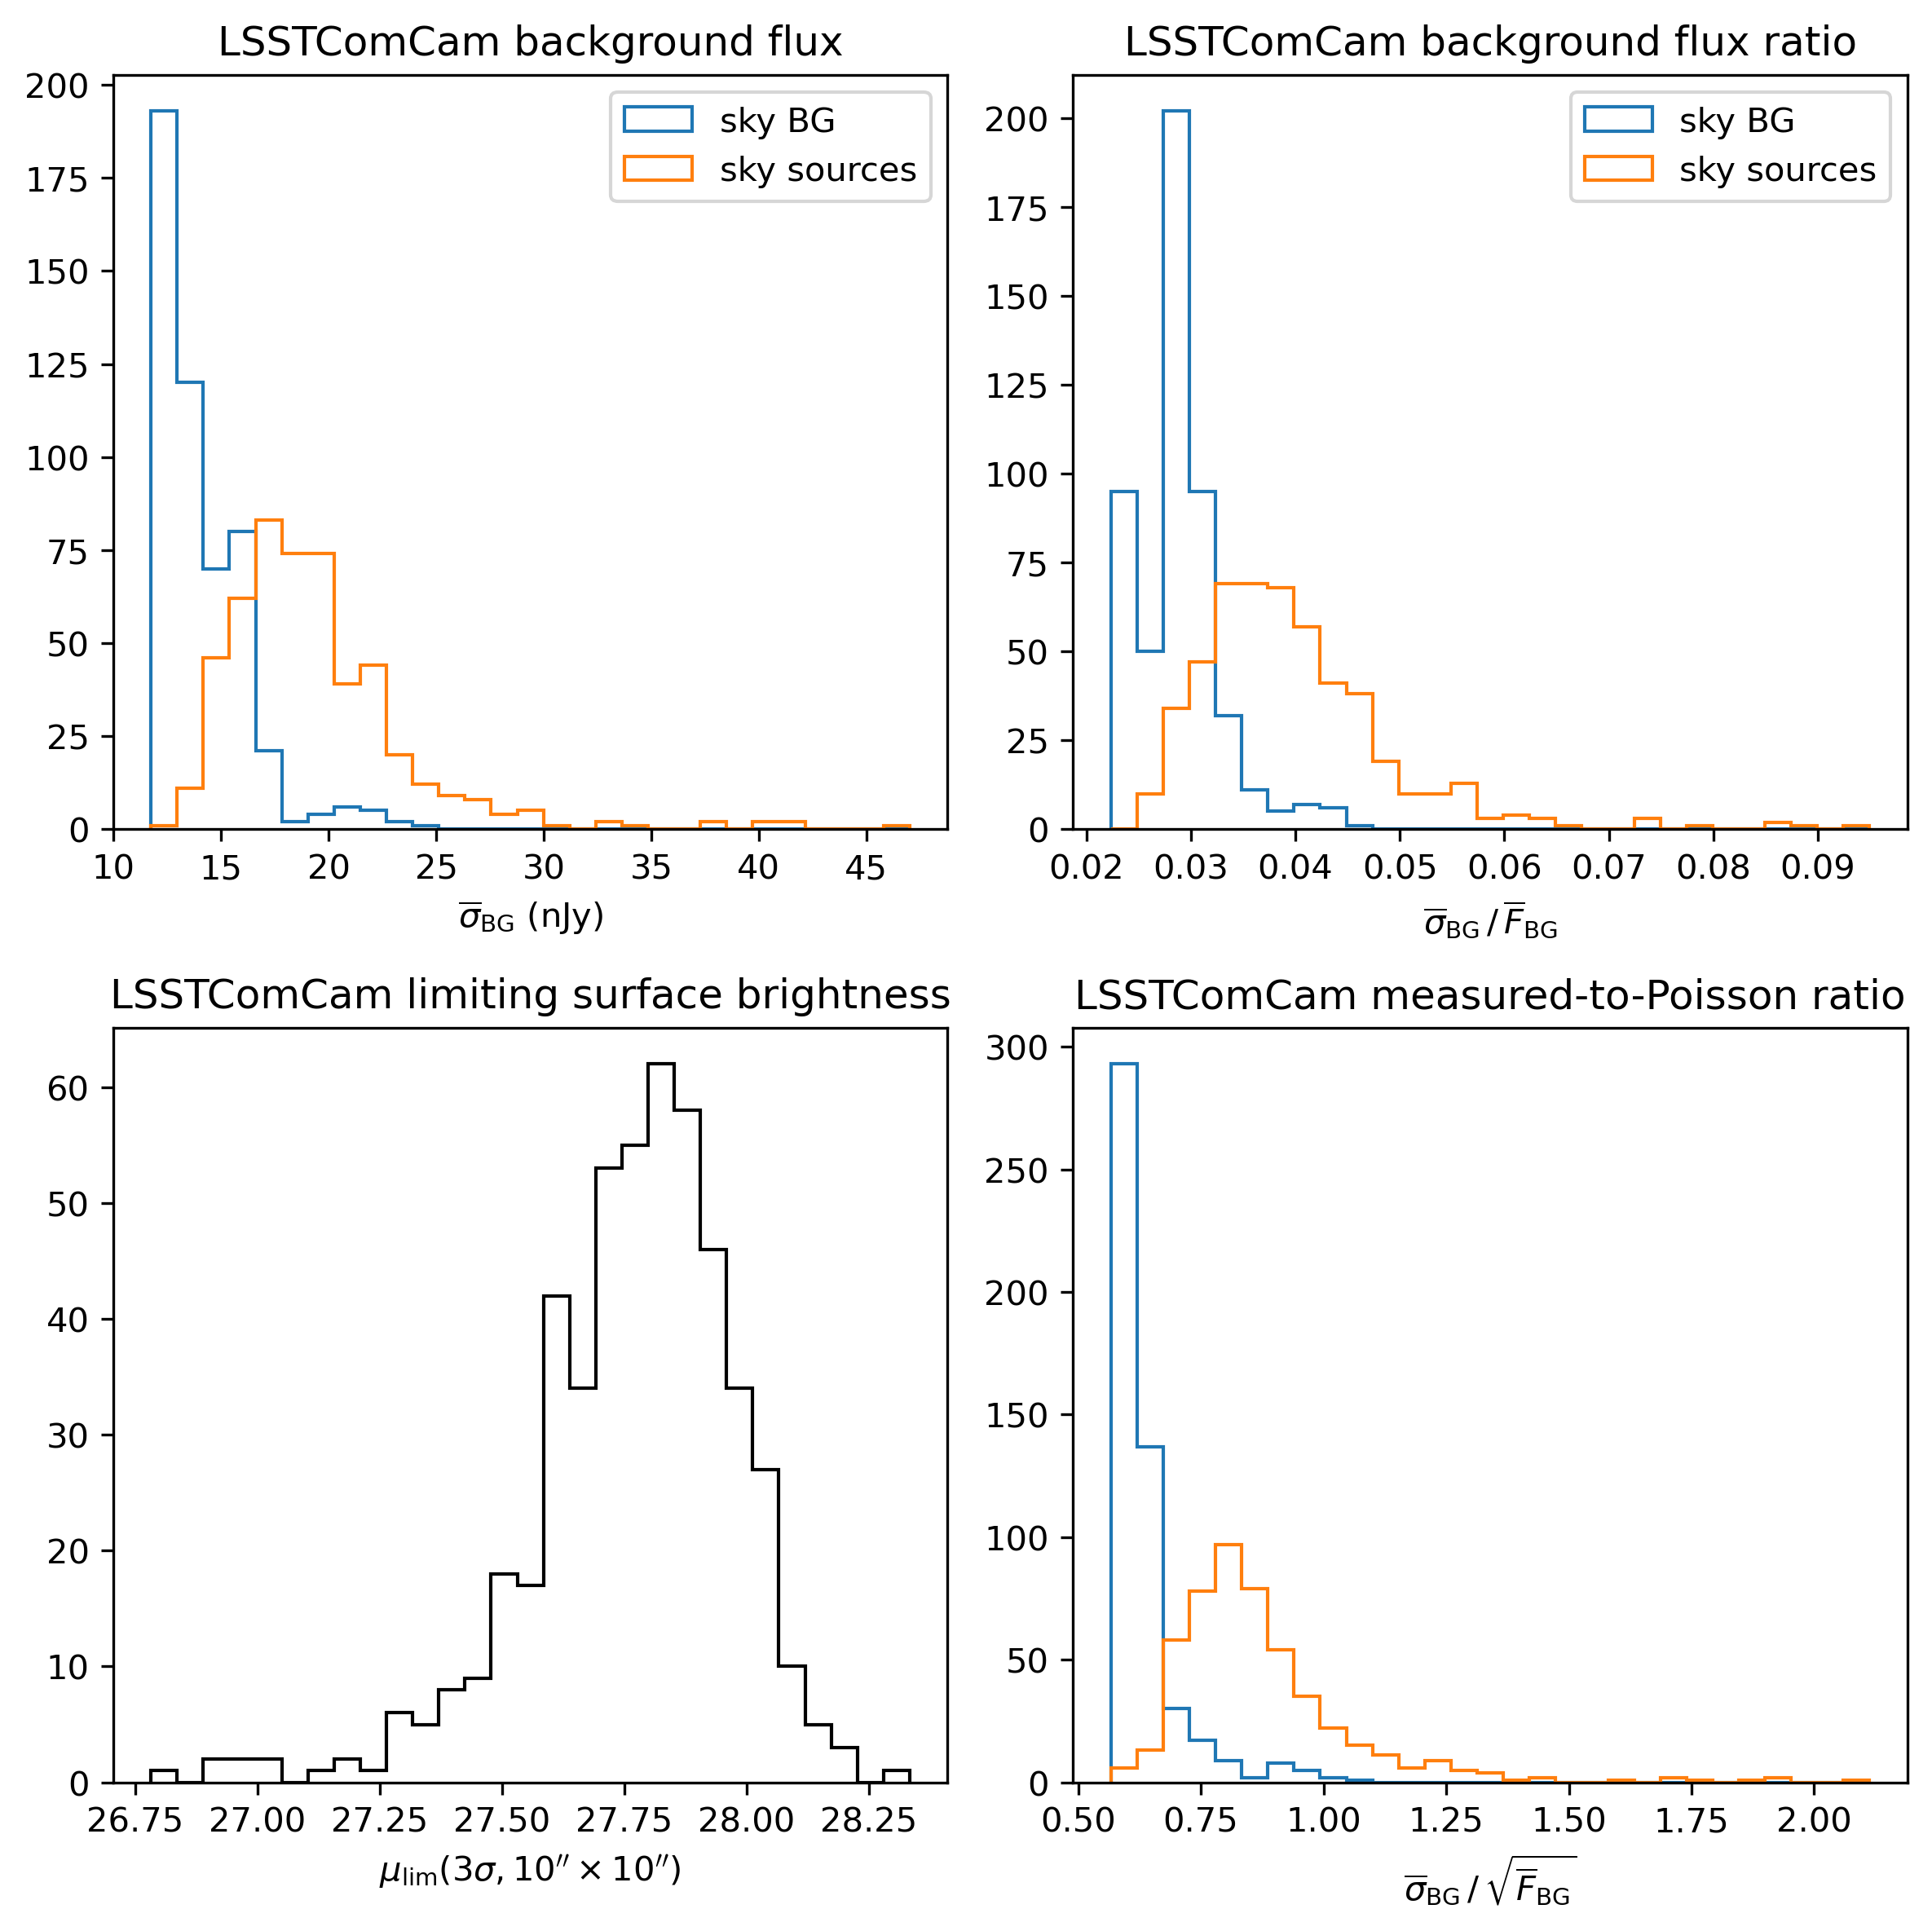

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=300)
axs = axs.flatten()

# Standard deviation
N = 30  # Number of histogram bins
axs[0].hist(
    sigSkyBgs,
    np.linspace(np.nanmin(sigSkyBgs), np.nanmax(sigSkySources), N),
    histtype="step",
    label="sky BG",
)
axs[0].hist(
    sigSkySources,
    np.linspace(np.nanmin(sigSkyBgs), np.nanmax(sigSkySources), N),
    histtype="step",
    label="sky sources",
)
axs[0].legend()
axs[0].set_xlabel(r"$\overline{\sigma}_{\rm BG}$ (nJy)")
axs[0].set_title(f"{instrument} background flux")

# Standard deviation / mean background flux
axs[1].hist(
    noiseFracBgs,
    np.linspace(np.nanmin(noiseFracBgs), np.nanmax(noiseFracSources), N),
    histtype="step",
    label="sky BG",
)
axs[1].hist(
    noiseFracSources,
    np.linspace(np.nanmin(noiseFracBgs), np.nanmax(noiseFracSources), N),
    histtype="step",
    label="sky sources",
)
axs[1].legend()
axs[1].set_xlabel(r"$\overline{\sigma}_{\rm BG}\, /\, \overline{F}_{\rm BG}$")
axs[1].set_title(f"{instrument} background flux ratio")

# Limiting surface brightness
axs[2].hist(muLims, np.linspace(np.nanmin(muLims), np.nanmax(muLims), N), histtype="step", color="k")
axs[2].set_xlabel(r"$\mu_{{\rm lim}} (3\sigma, 10^{\prime\prime}\times10^{\prime\prime})$")
axs[2].set_title(f"{instrument} limiting surface brightness")

# Standard deviation / expected Poisson noise
axs[3].hist(
    sigSkyBgsOnPoisson,
    np.linspace(np.nanmin(sigSkyBgsOnPoisson), np.nanmax(sigSkySourcesOnPoisson), N),
    histtype="step",
    label="sky BG",
)
axs[3].hist(
    sigSkySourcesOnPoisson,
    np.linspace(np.nanmin(sigSkyBgsOnPoisson), np.nanmax(sigSkySourcesOnPoisson), N),
    histtype="step",
    label="sky sources",
)
axs[3].set_xlabel(r"$\overline{\sigma}_{\rm BG}\, /\, \sqrt{\overline{F}_{\rm BG}}$")
axs[3].set_title(f"{instrument} measured-to-Poisson ratio")

plt.tight_layout()
plt.show()
plt.close()

Next we create violin plots showing distributions of standard deviations in sky-subtracted backgrounds for each visit (left panel), and distributions of ratios between those standard deviations and the mean sky brightness (right panel).

Values derived from image backgrounds are shown as blue violins, and values derived from sky sources are shown as orange violins.
To meet the stated requirements, the latter must be < 0.01 (red dotted line in right panel).
Red x's show the same metrics evaluated from sky sources.
To avoid clutter, we display only 10 visits.


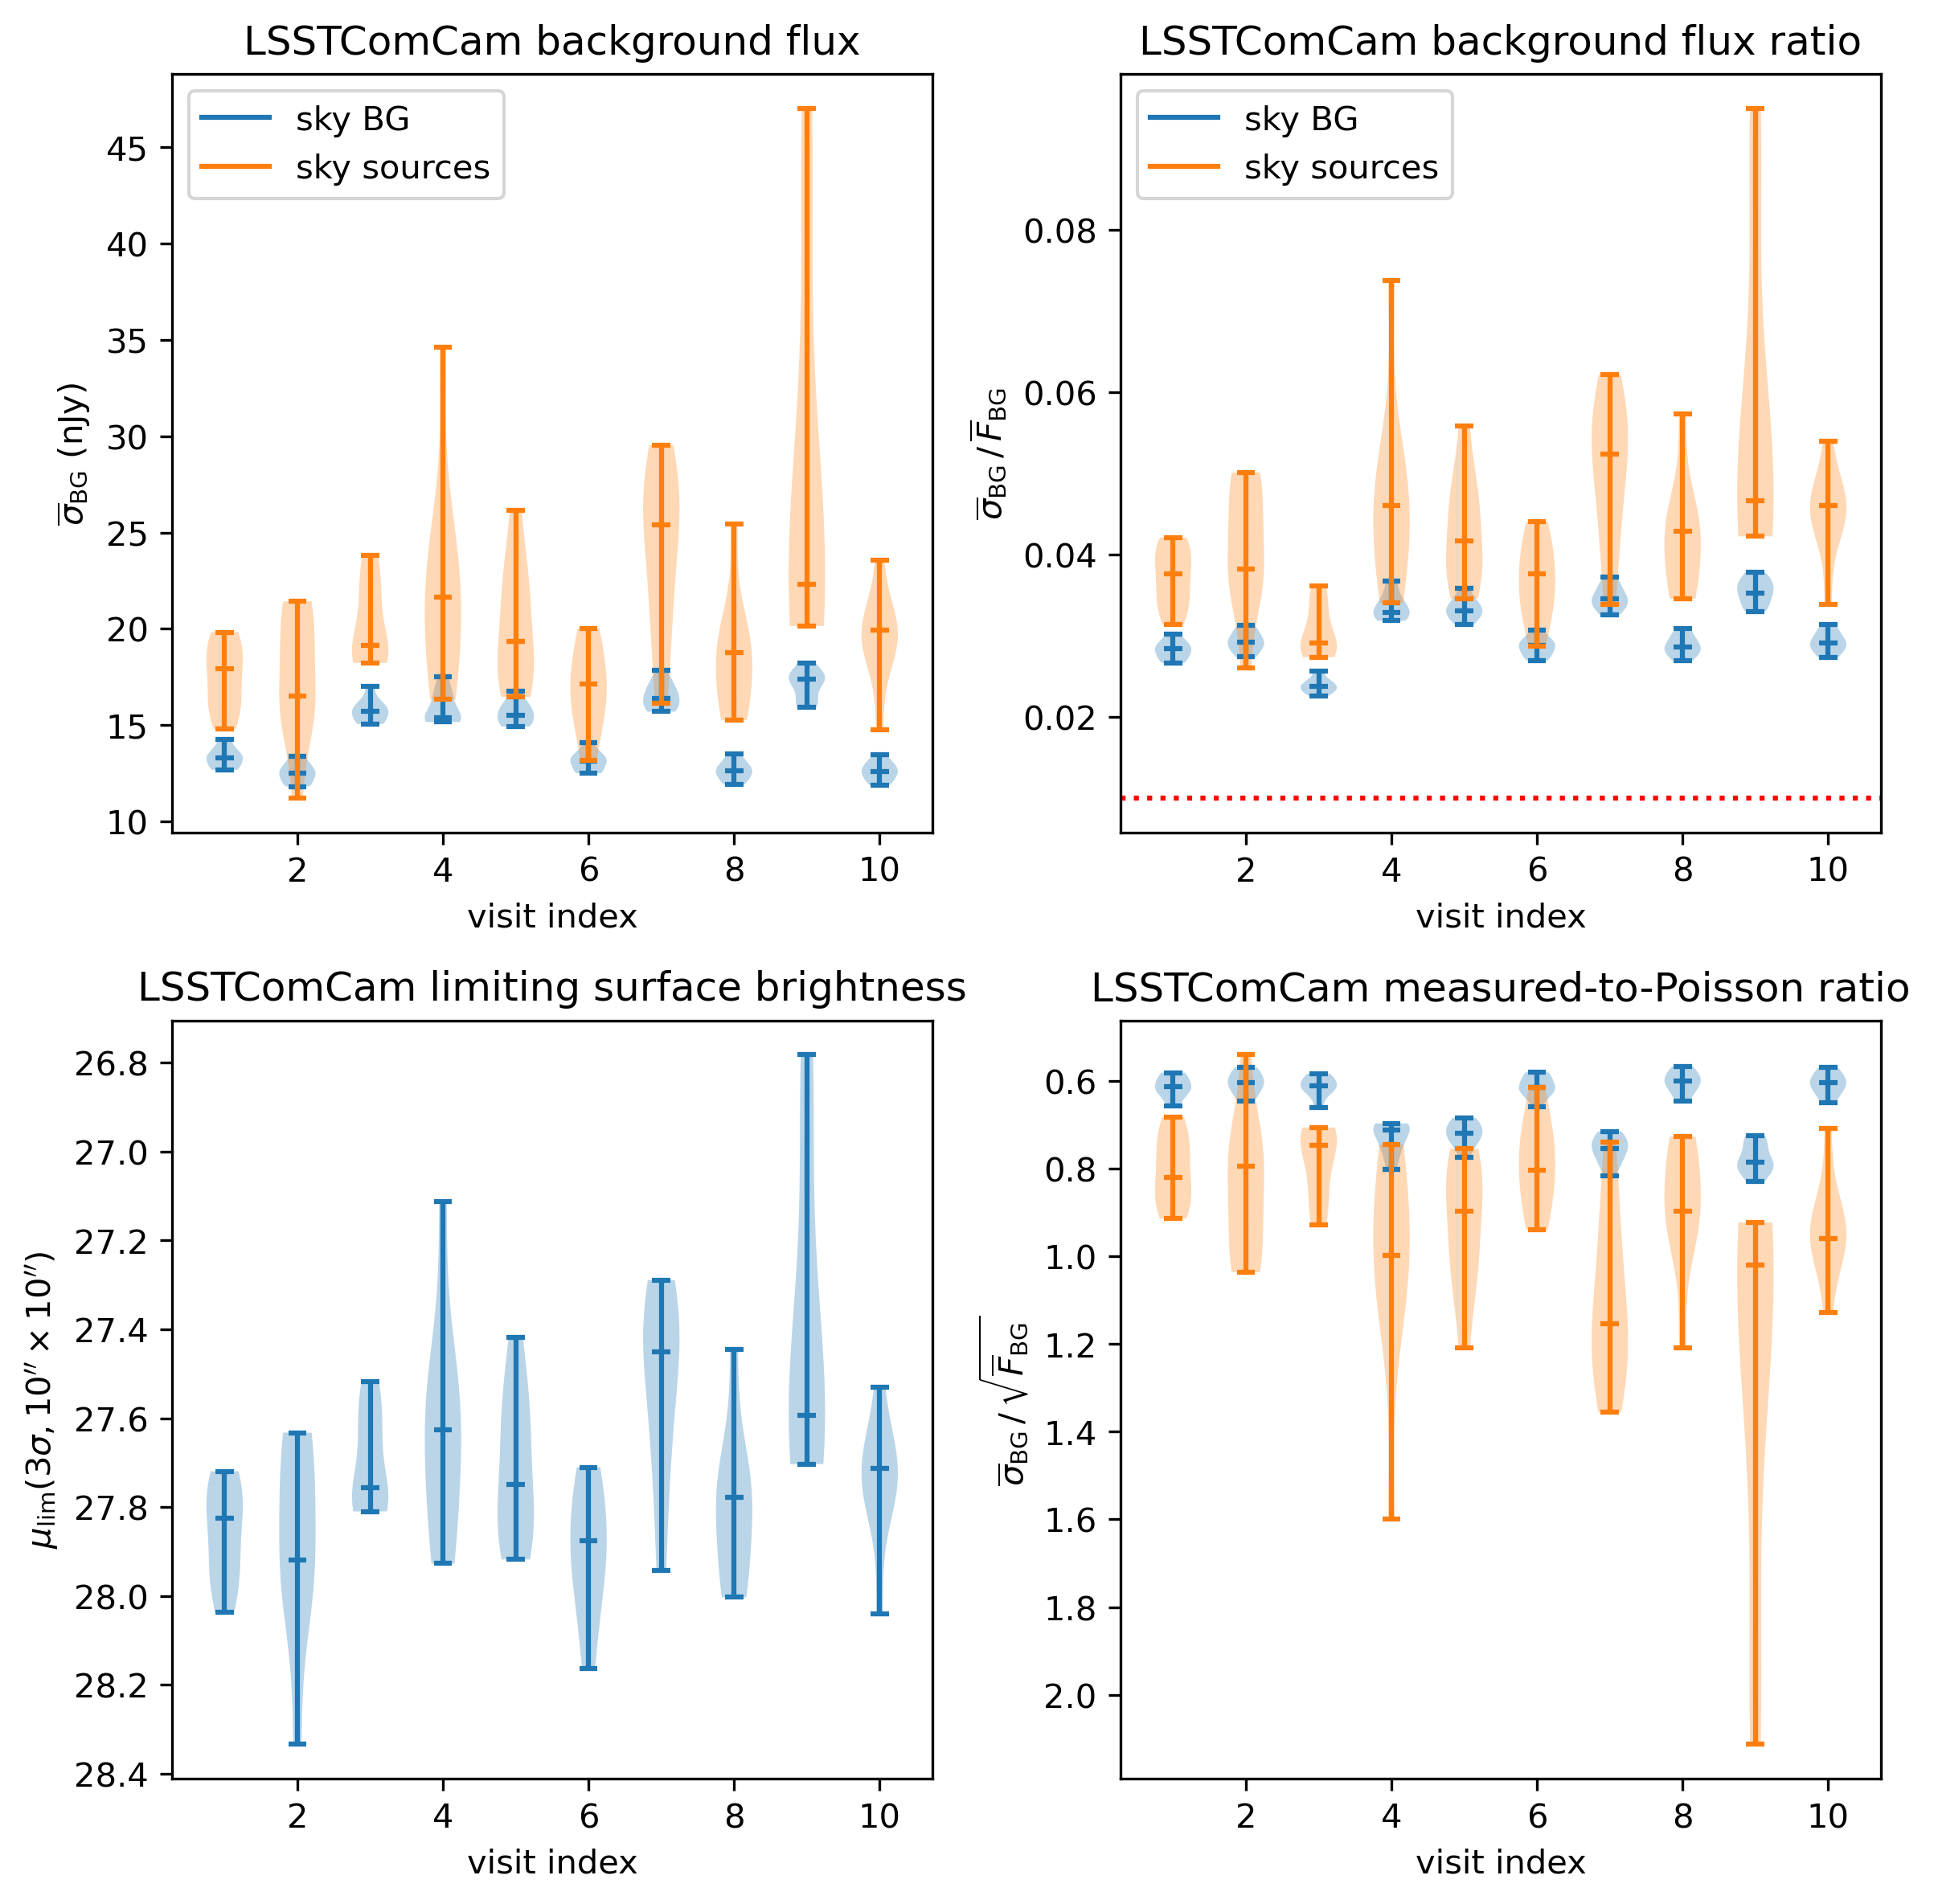

In [16]:
# Pick 10 visits of the full sample at random, or all if len < 10
if len(visits) < 10:
    idx = np.arange(len(visits))
else:
    rng = np.random.default_rng(12345)  # Set a seed for reproducibility
    idx = rng.choice(np.arange(len(visits)), size=10, replace=False)

fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=300)
axs = axs.flatten()

# Standard deviation
# From background flux distributions
axs[0].violinplot(
    [noiseDict[visits[i]]["sigSkyBg"] for i in idx],
    showmedians=True,
)
# From sky sources
axs[0].violinplot(
    [noiseDict[visits[i]]["sigSkySource"] for i in idx],
    showmedians=True,
)
legend_handles = [
    Line2D([0], [0], color="C0", label="sky BG"),
    Line2D([0], [0], color="C1", label="sky sources"),
]
axs[0].legend(handles=legend_handles)
axs[0].set_xlabel("visit index")
axs[0].set_ylabel(r"$\overline{\sigma}_{\rm BG}$ (nJy)")
axs[0].set_title(f"{instrument} background flux")

# Standard deviation / mean background flux
# From background flux distributions
axs[1].violinplot([noiseDict[visits[i]]["noiseFracBg"] for i in idx], showmedians=True)
# From sky sources
axs[1].violinplot([noiseDict[visits[i]]["noiseFracSource"] for i in idx], showmedians=True)
axs[1].axhline(0.01, c="r", linestyle=":")
axs[1].legend(handles=legend_handles)
axs[1].set_xlabel("visit index")
axs[1].set_ylabel(r"$\overline{\sigma}_{\rm BG}\, /\, \overline{F}_{\rm BG}$")
axs[1].set_title(f"{instrument} background flux ratio")

# Limiting surface brightness
axs[2].violinplot([noiseDict[visits[i]]["muLim"] for i in idx], showmedians=True)
axs[2].invert_yaxis()
axs[2].set_xlabel("visit index")
axs[2].set_ylabel(r"$\mu_{{\rm lim}} (3\sigma, 10^{\prime\prime}\times10^{\prime\prime})$")
axs[2].set_title(f"{instrument} limiting surface brightness")

# Standard deviation / expected Poisson noise
axs[3].violinplot([np.sqrt(np.array(noiseDict[visits[i]]["sigSkyBg"])
                           * np.array(noiseDict[visits[i]]["noiseFracBg"]))
                   for i in idx], showmedians=True)
axs[3].violinplot([np.sqrt(np.array(noiseDict[visits[i]]["sigSkySource"])
                           * np.array(noiseDict[visits[i]]["noiseFracSource"]))
                   for i in idx], showmedians=True)
axs[3].invert_yaxis()
axs[3].set_xlabel("visit index")
axs[3].set_ylabel(r"$\overline{\sigma}_{\rm BG}\, /\, \sqrt{\overline{F}_{\rm BG}}$")
axs[3].set_title(f"{instrument} measured-to-Poisson ratio")

plt.tight_layout()
plt.show()
plt.close()

#### Conclusion

We have demonstrated that the sky estimation precision metric `SBPerc` can be tested using `calexp` images, their associated `skyCorr` models, and the sky sources values stored in the `sourceTable_visit` tables produced by the Rubin Science Pipelines.

> As defined, The result of this test is "**Fail**"; in no visits do we find that `SBPerc < 1%`.

Alternatively, we tested this metric on images taken with the Burrell Schmidt Telescope (KPNO), an LSB-optimized telescope, which were processed using an LSB-optimized pipeline and heavily masked, and found values of $\sim2$% even there.
We've defined "precision" as effectively a signal-to-noise ratio.
As sky counts are expected to follow Poisson statistics, like every other source, S/N reduces with brighter skies, hence this metric is sensitive to the initial sky brightness.  We have demonstrated this by also deriving the measured vs. expected Poisson noise, which typically show values below 1, meaning the measured noise is lower than expected from the mean background flux.

**We therefore conclude that failure to satisfy the `SBPerc < 1%` criteria is not that concerning.**

As we do not expect to be able to reach the `SBPerc < 1%` threshold consistently, we propose using a metric more frequently employed by the low surface brightness community, based only on the background noise: the limiting surface brightness.
This is a value the LSB community will be interested in tracking throughout the survey, as more data is acquired and as the pipeline is refined, particularly on image coadds.


Reference: Roman, J., Trujillo, I., & Montes, M., 2020, A & A, 644, 42
